In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import re
import time
import random
from scipy.stats import poisson, norm
import pandas as pd
from scipy.sparse import csr_matrix,csc_matrix



import scipy.stats as stats


In [17]:
from lsmc import LMSC_optimize



movieId  1       2       3       6       7       10      11      13      \
userId                                                                    
200932      NaN     NaN     NaN     NaN     NaN     NaN     NaN     4.0   
200933      4.0     4.0     NaN     NaN     2.5     3.0     NaN     NaN   
200934      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
200935      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
200936      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
200937      NaN     3.0     NaN     NaN     NaN     NaN     NaN     NaN   
200938      4.5     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
200939      NaN     NaN     4.0     NaN     NaN     4.0     NaN     NaN   
200940      NaN     3.0     NaN     NaN     NaN     NaN     NaN     NaN   
200941      NaN     NaN     3.0     NaN     NaN     NaN     NaN     NaN   
200942      NaN     1.0     NaN     4.0     NaN     3.0     NaN     NaN   
200943      3.5     2.5  

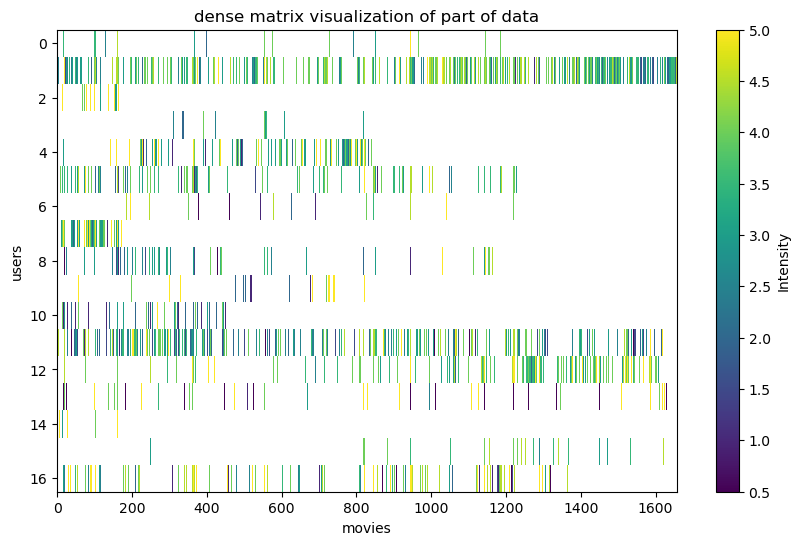

In [18]:


df = pd.read_csv('..\\data\\ratings.csv')


# het liefst heb je hieronder ipv df.tail(..) gewoon df (de hele dataset), maar dan krijg ik problemen.. 
matrix = pd.pivot_table(df.tail(3000), index='userId', columns='movieId', values='rating', aggfunc='mean')
print(matrix)

    
m = matrix.to_numpy()


def visualizeData(dense_matrix):
    # Create a figure and axis
    plt.figure(figsize=(10, 6))
    plt.imshow(dense_matrix, cmap='viridis', aspect='auto', interpolation='none')
    plt.colorbar(label='Intensity')
    plt.title('dense matrix visualization of part of data')
    plt.xlabel('movies')
    plt.ylabel('users')

    # Show the plot
    plt.show()


    
m = matrix.to_numpy()
visualizeData(m)

In [19]:
# now clip to remove all the low-intensity values
def clip_matrix(M, threshold=0.5):
    """
    Clips the values in matrix M, setting any value below the given threshold to 0.
    
    Args:
    - M (numpy array): The input matrix (values between 0 and 1).
    - threshold (float): The clipping threshold (default 0.5).
    
    Returns:
    - M_clipped (numpy array): A new matrix with values below the threshold set to 0.
    """
    # Ensure the input matrix is a numpy array
    M = np.array(M)
    
    # Clip values below the threshold by setting them to 0
    M_clipped = np.where(M < threshold, 0, M)
    
    return M_clipped




def probabilityMatrix(n_rows, n_cols, percentage):
    one_matrix = np.ones((n_rows, n_cols), dtype=int)
    num_cells = n_rows * n_cols
    num_zeros = int(percentage * num_cells)
    
    # Flatten the matrix to choose random indices
    flat_indices = np.random.choice(num_cells, num_zeros, replace=False)
    
    # Set these chosen indices to 0
    one_matrix.flat[flat_indices] = 0
    
    return one_matrix

def randomDiscard(M, ratio_keep):
    P = probabilityMatrix(M.shape[0], M.shape[1], ratio_keep)
    return np.multiply(M, P)


# now clip to remove all the low-intensity values
def clip_matrix(M, threshold=0.5):
    """
    Clips the values in matrix M, setting any value below the given threshold to 0.
    
    Args:
    - M (numpy array): The input matrix (values between 0 and 1).
    - threshold (float): The clipping threshold (default 0.5).
    
    Returns:
    - M_clipped (numpy array): A new matrix with values below the threshold set to 0.
    """
    # Ensure the input matrix is a numpy array
    M = np.array(M)
    
    # Clip values below the threshold by setting them to 0
    M_clipped = np.where(M < threshold, 0, M)
    
    return M_clipped



def generate_matrix_with_rank(m, n, r):
    assert r <= min(m, n), "Rank r must be less than or equal to the smaller of m or n."
    
    # Generate two random matrices of size m x r and r x n
    A = np.random.rand(m, r)
    B = np.random.rand(r, n)
    
    # Multiply A and B to get a matrix of size m x n with rank r
    matrix = np.dot(A, B)
    
    return matrix


def threshold_percentage(data, percentage):
    mu = np.mean(data)
    sigma = np.std(data)
    return mu + sigma * stats.norm.ppf(1-percentage)


def partlyDiscardedClipping(data_matrix, uniform_ratio_keep, threshold=None, threshold_ratio_keep=0.6):
    # Create a figure and axis for the original matrix
    fig, ax = plt.subplots(figsize=(6, 6))  # Keeping aspect ratio

    # Plot the matrix with a color scale
    cax = ax.matshow(data_matrix, cmap='viridis')

    # Add colorbar to show the scale
    fig.colorbar(cax)

    # Show the plot
    plt.show()
    
    # Randomly discard values to create an imperfect matrix
    imperfect_matrix = randomDiscard(data_matrix, 1 - uniform_ratio_keep)

    # Replace zeros in the imperfect matrix with NaN
    imperfect_matrix_with_nan = np.where(imperfect_matrix == 0, np.nan, imperfect_matrix)

    
    # Create a figure and axis for the imperfect matrix
    fig, ax = plt.subplots(figsize=(6, 6))  # Keeping aspect ratio

    # Plot the imperfect matrix with NaN values
    cax = ax.matshow(imperfect_matrix_with_nan, cmap='viridis')

    # Add colorbar to show the scale
    fig.colorbar(cax)

    # Show the plot
    plt.show()

    if threshold is None:
        threshold = threshold_percentage(data_matrix, threshold_ratio_keep)

    # Clip the imperfect matrix
    clipped_imperfect_matrix = clip_matrix(imperfect_matrix, threshold)

    # Replace zeros in the clipped matrix with NaN
    clipped_imperfect_matrix_with_nan = np.where(clipped_imperfect_matrix == 0, np.nan, clipped_imperfect_matrix)
    
    
    # Create a figure and axis for the clipped matrix
    fig, ax = plt.subplots(figsize=(6, 6))  # Keeping aspect ratio

    # Plot the clipped matrix with NaN values
    cax = ax.matshow(clipped_imperfect_matrix_with_nan, cmap='viridis')

    # Add colorbar to show the scale
    fig.colorbar(cax)

    # Show the plot
    plt.show()

    return clipped_imperfect_matrix


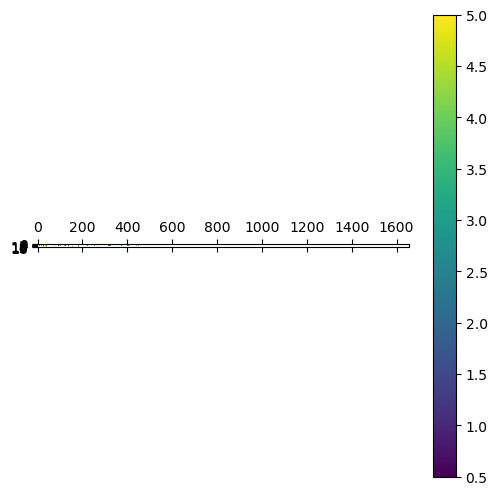

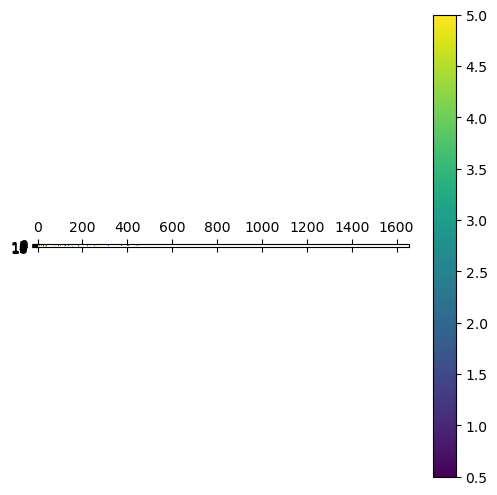

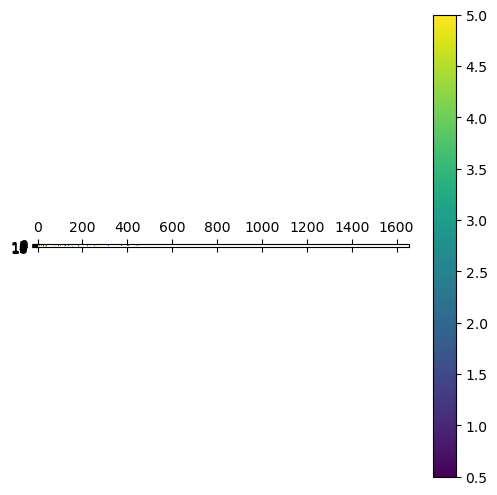

LinAlgError: SVD did not converge

In [20]:

rows, cols = m.shape

R = m
P_init = partlyDiscardedClipping(data_matrix=m, uniform_ratio_keep=0.9, threshold=None, threshold_ratio_keep=0.7)
u_init = np.zeros((rows, cols))
y_init = np.zeros((rows, cols)) 
s_init = 1 # ?
rho = 10000 # ? 
lambda_ = 0.4 #vanuit de grafiek als minimum bij de foods

delta = 1e-3 #convention?!?
num_iterations = 1000

# gamma γ = 0, 0.001 and 0.01. 
gamma = 0.01 #een van de 3 mogelijkheden
epsilon =rows*cols*gamma # uit de paper

P_final, Z_final, u_final, y_final, s_final, errors = LMSC_optimize(rho, lambda_, R, P_init, u_init, y_init, s_init, delta, epsilon, num_iterations)

print("Final R:", R)
print("Final P:", P_final)
print("Final Z:", Z_final)
print("Final u:", u_final)
print("Final y:", y_final)
print("Final s:", s_final)

# print("Error:", error(P_final, R))

S_1 = y_init / rho + R - u_init
Q, Sigma, W = np.linalg.svd(S_1, full_matrices=False)
# print(f"Singular values before thresholding: {Sigma}")
# Sigma_prox = soft_threshold(Sigma, 1/rho)
# print(f"Singular values after thresholding: {Sigma_prox}")

In [ ]:
LMSC_optimize()